MEDJKOUNE Roumaissa 191931081005 G2
BEDJBEDJ Hani Abderrahmane 191931090506 G2

# TP 1 Mesures de performance
Dans ce TP, nous aimerions avoir un premier apperçu sur les algorithmes d'apprentissage automatique. Plus précisément, nous aimerions évaluer leurs performances en utilisant les métriques suivantes:
- Matrice de conusion
- Rappel
- Précision
- Taux de FP
- Spécificité
- Courbe ROC

Les mesures devront être calculées sur la tâche de classification de nombres manuscrits.

Le travail consiste à implementer ces métriques et à les comparer avec les métriques des librairies disponibles.

Les algorithmes : K plus Proches Voisins devront être implementés.

# Importation des librairies necessaires au travail

In [482]:
import numpy as np
import pandas as pd
import math
import cv2 
import matplotlib.pyplot as plt
from numpy import random
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
from sklearn import metrics

In [350]:
# Pour RNC
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD

In [351]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score

# Lecture des fichiers de données à classifier
Pour ce TP, nous allons lire les données à partir d'un fichier csv.

In [352]:
# données
X = np.genfromtxt('data.csv', delimiter=',', dtype=int)
X.shape
df = pd.read_csv("data.csv",nrows=5000)

In [353]:
# étiquettes
Y = np.genfromtxt('labels.csv', delimiter=',', dtype=int)
Y.shape

(5000,)

In [354]:
X.shape

(5000, 400)

Afficher aléatoirement quelques données de notre base

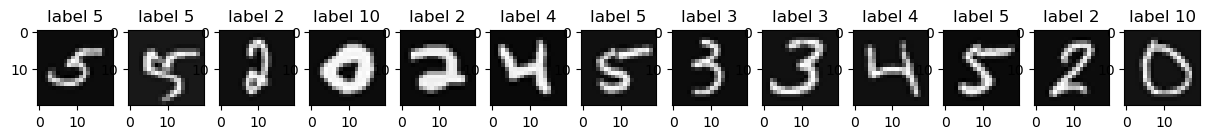

In [355]:
plt.figure(figsize=(15,8))
for i in range(13): #note: each 500 lines, there is a new value
    c = random.randint(X.shape[0]) #pick a random line from the dataset 
    a = X[c,:].reshape((20, 20)) #shape of one number in the image 
    a=np.transpose(a) # la transposé (rendre les ligne des colonne et vice versa)
    plt.subplot(1,13,i+1)
    plt.title('label '+ str(Y[c]))
    plt.imshow(a,cmap='gray')

Notons que l'étiquette 10 concerne le chiffre 0. L'étiquette a été utilisée ainsi afin de faciliter les calculs conséquents.

# Implémentation des métriques demandées
Ici il faut écrire les fonctions, puis les appeler dans la suite du code

Comme il s'agit d'un probleme de classification multiclasse avant de calculer les metrics ci dessous nous construisons la matrice de confusions et extraire FP,FN,TP,TN total:

Extraire les metrics a partir de la matrice de confusion

In [459]:
def confusionMatrix(original,pred): #passer les deux labels predit et test 
    n= len(np.unique(original))  #la taille de la matrice
    M=np.zeros((n,n)) # matrice initialisee par des 0 de taille n*n
    pred=pred.astype(int)
    for i in range(len(original)): #remplir la matrice
        M[original[i]-1,pred[i]-1]+=1;
    return M

In [242]:
def TP(M):
    TP=np.trace(M) # les vrai positifs = la diagonale
    return TP

In [243]:
def FN(M):
    rows=np.sum(M,axis=1) # les faux négatifs = la somme des lignes moin les vrai positifs
    FN=np.sum(rows)-TP(M)
    return FN

In [251]:
def FP(M):
    cols=np.sum(M,axis=0) # les faux positifs = la somme des colonnes moin les vrai positifs
    FP=np.sum(cols)-TP(M)
    return FP

In [252]:
def TN(M):
    TN= np.sum(M)-(TP(M)+FN(M)+FP(M)) # les vrai negatifs = la somme de la matrice moins les autres métriques
    return TN 

- Rappel

In [255]:
def Rappel(M):
    return (TP(M)/(TP(M)+FN(M)))

- Précision

In [260]:
def precision(M):
    return (TP(M)/(TP(M)+FP(M)))

- Accuracy

In [375]:
def accuracy(M):
    return (TP(M)+TN(M))/np.sum(M)

- Taux de FP

In [261]:
def FPR(M):
    return (FP(M) / (FP(M) + TN(M)))

- Spécificité

In [271]:
def specificity(M):
    return (TN(M)/(FP(M)+TN(M)))

- Courbe ROC

In [495]:
# pour creer la  courbe roc  d'une classe en plus des labels et des prédiction on précise la classe c et aussi les seuils 
def Courbe_ROC(y_test, y_pred,c,ths):
    def extract(m):
        TP=m.diagonal() 
        FN=np.sum(m,axis=1)-TP 
        FP=np.sum(m,axis=0)-TP 
        TN= np.full(m.shape[0], np.sum(m))-(TP+FN+FP)
        return TP,FN,FP,TN
    
    def Recall(TP,FN):
        Recall=TP /(TP  + FN)
        return Recall
    
    def Taux_FP(FP,TN):
        Taux_FP=FP /(FP  + TN)
        return Taux_FP
    
    #liste des Taux de faux positif et vrai positif 
    fpr=[]
    tpr=[]
    # selectionner le vecteur de proba de la classe c
    pred=y_pred[:,c]
    #transformer les labels 
    test=np.copy(y_test)
    test[test==c]=10
    test[test<10]=0
    test[test==10]=1
    for th in ths:
        predth=np.copy(pred)
        predth[predth<th]=0
        predth[predth>=th]=1
        #Taux de faux positif et vrai positif en utilisant les fonctions predefinies
        m=confusionMatrix(test, predth)
        TP,FN,FP,TN=extract(m)
        fpr.append(Taux_FP(FP,TN)[1])
        tpr.append(Recall(TP,FN)[1])
    return fpr,tpr

In [497]:
def roc_class(y_test,y_pred):
    fprs=[]
    tprs=[]
    rocs=[]
    fprs1=[]
    tprs1=[]
    rocs1=[]  
    for c in range (0,10): 
        Yttt=np.copy(y_test)
        Yttt[Yttt==c]=10
        Yttt[Yttt<10]=0
        Yttt[Yttt==10]=1
        pp=y_pred[:,c]
        fpr,tpr,th=metrics.roc_curve(Yttt,pp)
        auc = metrics.auc(fpr, tpr)  # calcule du AUC
        fprs.append(fpr)
        tprs.append(tpr)
        rocs.append(auc)
        fpr1,tpr1=Courbe_ROC(y_test, y_pred,c,th)
        auc1=np.trapz(tpr1,fpr1) 
        fprs1.append(fpr1)
        tprs1.append(tpr1)
        rocs1.append(auc1)
        
    return  fprs,tprs,rocs,fprs1,tprs1,rocs1  

In [498]:
#tracer les courbes
def roc_figure(fprs,tprs,rocs) :
    plt.figure()
    lw = 2 
    for i in range (0,10): 
        plt.plot(fprs[i], tprs[i],lw=lw, label='Class'+str(i)+' ROC curve (AUC = %0.2f)' % rocs[i])
    plt.plot([0, 1], [0, 1], color='yellow', lw=lw, linestyle='--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curves')
    plt.legend(loc="lower right")
    plt.show()

# Classification

Définir d'abord la base d'entrainement Xt, Yt et la base de test Xtt, Ytt

In [356]:

scaler = StandardScaler()
scaler.fit(X)
scaled_features = scaler.transform(X)
Xt, Xtt, Yt, Ytt = train_test_split(
      scaled_features, Y, test_size = 0.30)

# Méthode 0: K- Plus Proches Voisins

Ici il faudra implémenter la méthode, puis la tester et vérifier les métriques en variant le nombre K

In [489]:
def euclidean_dist(pointA, pointB):
    #Calculer distance euclidienne entre 2 vecteurs numpy 
    distance = np.square(pointA - pointB) # (ai-bi)**2 for every point in the vectors
    distance = np.sum(distance) # adds all values
    distance = np.sqrt(distance) 
    return distance

def distance_from_all_training(test_point):
   #Calculer distance euclidienne entre test point Xtt et tous les points dans XT"""
    dist_array = np.array([])
    for train_point in Xt:
        dist = euclidean_dist(test_point, train_point)
        dist_array = np.append(dist_array, dist)
    return dist_array


Selecting k-nearest neighbors and making the prediction

In [452]:
def predict(train_features, train_target, test_features, k = 5):
    #appliquer KNN classification 
    
    predictions = np.array([])
    train_target = train_target.reshape(-1,1)
    for test_point in test_features: # iterating through every test data point 
        dist_array = distance_from_all_training(test_point).reshape(-1,1) # calculating distance from every training data instance
        neighbors = np.concatenate((dist_array, train_target), axis = 1) 
        neighbors_sorted = neighbors[neighbors[:, 0].argsort()] # sorts training points on the basis of distance
        k_neighbors = neighbors_sorted[:k] # selects k-nearest neighbors
        frequency = np.unique(k_neighbors[:, 1], return_counts=True)
        target_class = frequency[0][frequency[1].argmax()] # selects label with highest frequency
        predictions = np.append(predictions, target_class)
    
    return predictions

In [465]:
def predict_proba(train_features, train_target, test_features, k = 5):
    # appliquer KNN classification 
    
    predictions = np.array([])
    train_target = train_target.reshape(-1,1)
    for test_point in test_features: # iterating through every test data point 
        dist_array = distance_from_all_training(test_point).reshape(-1,1) # calculating distance from every training data instance
        neighbors = np.concatenate((dist_array, train_target), axis = 1) 
        neighbors_sorted = neighbors[neighbors[:, 0].argsort()] # sorts training points on the basis of distance
        k_neighbors = neighbors_sorted[:k] # selects k-nearest neighbors
        
        # calculate class probabilities
        frequency = np.unique(k_neighbors[:, 1], return_counts=True)
        class_counts = np.zeros(len(np.unique(train_target)))
        class_counts[frequency[0].astype(int)-1] = frequency[1] 
        class_probs = class_counts/np.sum(class_counts)
        
        target_class = frequency[0][frequency[1].argmax()] # selects label with highest frequency
        predictions = np.append(predictions, class_probs)
    
    return predictions

    


In [453]:
y_pred = predict(Xt,Yt,Xtt, k = 5)
y_pred

array([ 2.,  8.,  3., ...,  9., 10.,  8.])

# les métriques de sklearn

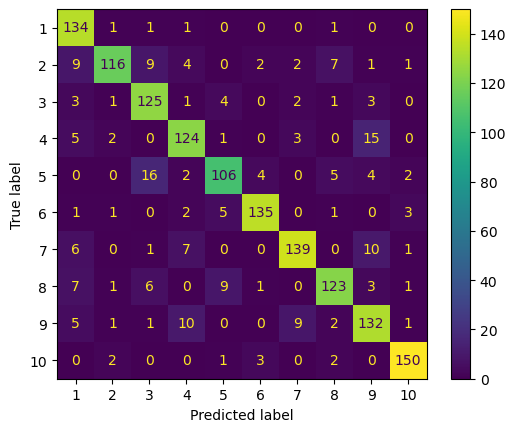

In [419]:
cm=confusion_matrix(Ytt,y_pred,labels=model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot()
plt.show()


Sklearn dispose des fonctions predefinies pour calculer la precision et le rappel main ne permet pas de calculer le taux de FP et specifiicty dans le cas de classification multi-classe

In [420]:
from sklearn.metrics import classification_report
print(classification_report(Ytt,y_pred))

              precision    recall  f1-score   support

           1       0.79      0.97      0.87       138
           2       0.93      0.77      0.84       151
           3       0.79      0.89      0.84       140
           4       0.82      0.83      0.82       150
           5       0.84      0.76      0.80       139
           6       0.93      0.91      0.92       148
           7       0.90      0.85      0.87       164
           8       0.87      0.81      0.84       151
           9       0.79      0.82      0.80       161
          10       0.94      0.95      0.95       158

    accuracy                           0.86      1500
   macro avg       0.86      0.86      0.86      1500
weighted avg       0.86      0.86      0.86      1500



In [421]:
print(f"Precision: {precision_score(Ytt, y_pred, average='macro')}")
print(f"Rappel:{recall_score(Ytt, y_pred, average='macro')}")


Precision: 0.8587977081915179
Rappel:0.8564875690065659


Courbe ROC avec sklearn


C:\Users\Lenovo\anaconda3\envs\my-env\lib\site-packages\sklearn\metrics\_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


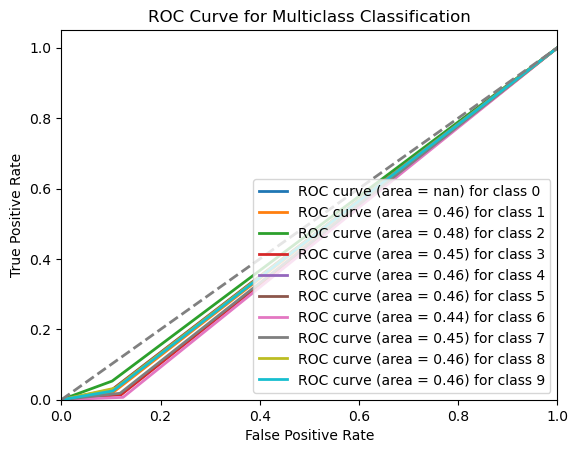

In [422]:
print("Courbe ROC avec sklearn")
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr = dict()
tpr = dict()
roc_auc = dict()
y_pred=model.predict_proba(Xtt)
for i in range(len(set(Ytt))):
    fpr[i], tpr[i], _ = roc_curve(Ytt,[y_pred[j][i] for j in range(len(y_pred))], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
lw = 2
for i in range(len(set(Ytt))):
    plt.plot(fpr[i], tpr[i], lw=lw, label='ROC curve (area = %0.2f) for class %d' % (roc_auc[i], i))
plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()


# les métriques implementées pour voir le résultat

In [460]:
M=confusionMatrix(Ytt,y_pred)
M

array([[134.,   1.,   1.,   1.,   0.,   0.,   0.,   1.,   0.,   0.],
       [  9., 116.,   9.,   4.,   0.,   2.,   2.,   7.,   1.,   1.],
       [  3.,   1., 125.,   1.,   4.,   0.,   2.,   1.,   3.,   0.],
       [  5.,   2.,   0., 124.,   1.,   0.,   3.,   0.,  15.,   0.],
       [  0.,   0.,  16.,   2., 106.,   4.,   0.,   5.,   4.,   2.],
       [  1.,   1.,   0.,   2.,   5., 135.,   0.,   1.,   0.,   3.],
       [  6.,   0.,   1.,   7.,   0.,   0., 139.,   0.,  10.,   1.],
       [  7.,   1.,   6.,   0.,   9.,   1.,   0., 123.,   3.,   1.],
       [  5.,   1.,   1.,  10.,   0.,   0.,   9.,   2., 132.,   1.],
       [  0.,   2.,   0.,   0.,   1.,   3.,   0.,   2.,   0., 150.]])

In [461]:
print('Rappel:'+str(Rappel(M)))
print('precision :' +str(precision(M)))
print(f"Accuracy: {accuracy(M)}")
print('Specificity:'+str(specificity (M)))
print('Taux de FP:'+str(FPR(M)))

Rappel:0.856
precision :0.856
Accuracy: 0.712
Specificity:-inf
Taux de FP:inf


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1928\4024345619.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  return (TN(M)/(FP(M)+TN(M)))
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1928\2444885879.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  return (FP(M) / (FP(M) + TN(M)))


In [466]:
proba=predict_proba(Xt,Yt,Xtt,k=5)

In [478]:
proba.shape,Ytt.shape

((15000,), (1500,))

In [479]:
h=proba.reshape((1500,10))

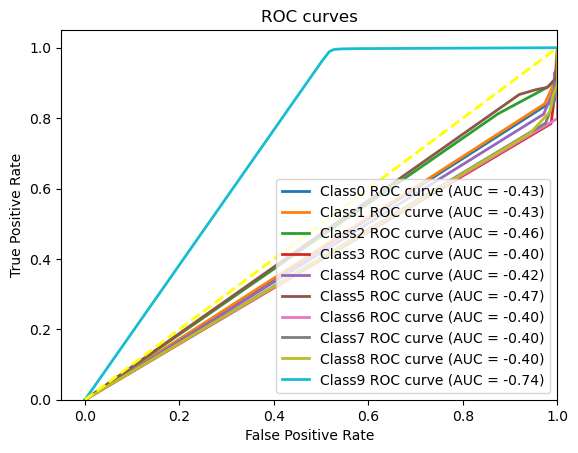

In [494]:
_,_,_,fprs1,tprs1,rocs1 =roc_class(Ytt,h)
roc_figure(fprs1,tprs1,rocs1) 

# Méthode 1: MVS
Machine à Vecteurs de Support

In [499]:
#Créer le modèle
model= svm.SVC(kernel='linear',probability=True) 
# entrainement 
model.fit(Xt, Yt)
# Prediction
y_pred = model.predict(Xtt)

In [500]:
y_pred

array([ 2,  8,  3, ...,  9, 10,  8])

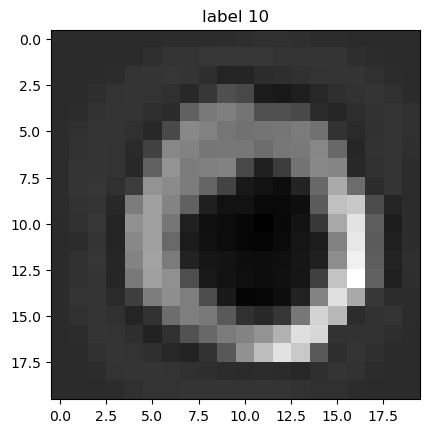

In [359]:
# tester une image
c= 3
y_pred[c]
a = Xtt[c,:].reshape((20, 20))
a=np.transpose(a)
plt.title('label '+ str(Ytt[c]))
plt.imshow(a,cmap='gray')

# les métriques de sklearn

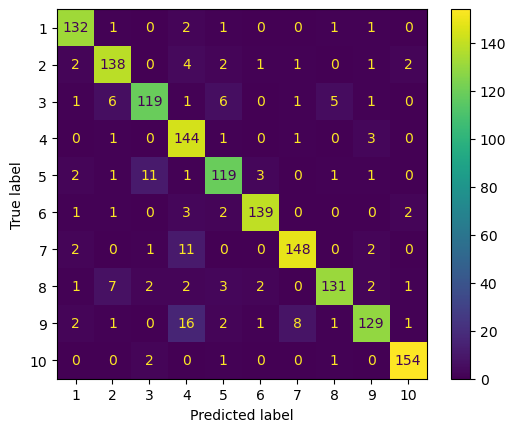

In [360]:
cm=confusion_matrix(Ytt,y_pred,labels=model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot()
plt.show()


Sklearn dispose des fonctions predefinies pour calculer la precision et le rappel main ne permet pas de calculer le taux de FP et specifiicty dans le cas de classification multi-classe

In [378]:
from sklearn.metrics import classification_report
print(classification_report(Ytt,y_pred))

              precision    recall  f1-score   support

           1       0.92      0.96      0.94       138
           2       0.88      0.91      0.90       151
           3       0.88      0.85      0.87       140
           4       0.78      0.96      0.86       150
           5       0.87      0.86      0.86       139
           6       0.95      0.94      0.95       148
           7       0.93      0.90      0.92       164
           8       0.94      0.87      0.90       151
           9       0.92      0.80      0.86       161
          10       0.96      0.97      0.97       158

    accuracy                           0.90      1500
   macro avg       0.90      0.90      0.90      1500
weighted avg       0.91      0.90      0.90      1500



In [313]:
print(f"Precision: {precision_score(Ytt, y_pred, average='macro')}")
print(f"Rappel:{recall_score(Ytt, y_pred, average='macro')}")


Precision: 0.9049418883223321
Rappel:0.9037839224586408


Courbe ROC avec sklearn


C:\Users\Lenovo\anaconda3\envs\my-env\lib\site-packages\sklearn\metrics\_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


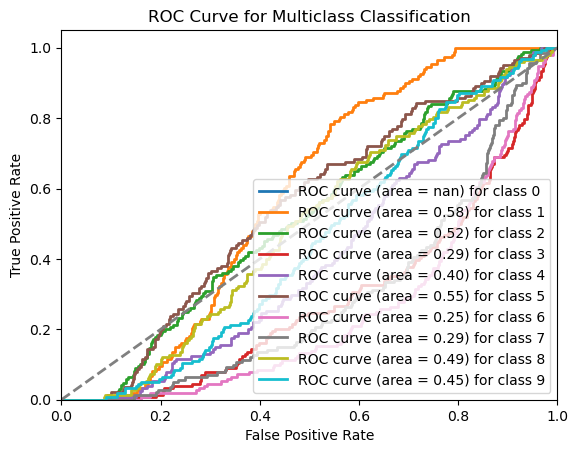

In [314]:
print("Courbe ROC avec sklearn")
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr = dict()
tpr = dict()
roc_auc = dict()
y_pred=model.predict_proba(Xtt)
for i in range(len(set(Ytt))):
    fpr[i], tpr[i], _ = roc_curve(Ytt,[y_pred[j][i] for j in range(len(y_pred))], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
lw = 2
for i in range(len(set(Ytt))):
    plt.plot(fpr[i], tpr[i], lw=lw, label='ROC curve (area = %0.2f) for class %d' % (roc_auc[i], i))
plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()


# les métriques implementées pour voir le résultat

In [247]:
M=confusionMatrix(Ytt,y_pred)
M

array([[143.,   1.,   2.,   0.,   1.,   0.,   0.,   1.,   0.,   0.],
       [  2., 153.,   4.,   3.,   0.,   2.,   1.,   4.,   0.,   0.],
       [  1.,   6., 135.,   1.,   6.,   0.,   1.,   3.,   1.,   0.],
       [  0.,   3.,   0., 140.,   1.,   1.,   1.,   1.,   7.,   0.],
       [  2.,   3.,   7.,   2., 118.,   3.,   0.,   3.,   1.,   0.],
       [  0.,   2.,   0.,   2.,   1., 145.,   0.,   1.,   0.,   1.],
       [  0.,   3.,   0.,   1.,   0.,   0., 130.,   0.,   7.,   0.],
       [  0.,   3.,   7.,   2.,   6.,   1.,   0., 126.,   2.,   1.],
       [  3.,   1.,   2.,  12.,   2.,   0.,   3.,   3., 128.,   1.],
       [  0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   1., 137.]])

In [382]:
print('Rappel:'+str(Rappel(M)))
print('precision :' +str(precision(M)))
print(f"Accuracy: {accuracy(M)}")
print('Specificity:'+str(specificity (M)))
print('Taux de FP:'+str(FPR(M)))

Rappel:0.26057142857142856
precision :0.26057142857142856
Accuracy: -0.47885714285714287
Specificity:-inf
Taux de FP:inf


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1928\4024345619.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  return (TN(M)/(FP(M)+TN(M)))
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1928\2444885879.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  return (FP(M) / (FP(M) + TN(M)))


# Méthode 2: Arbres de décision


In [383]:
# Créer le modèle
model = DecisionTreeClassifier()
# Entrainer le modèle
model = model.fit(Xt, Yt)
# Prediction
y_pred = model.predict(Xtt)

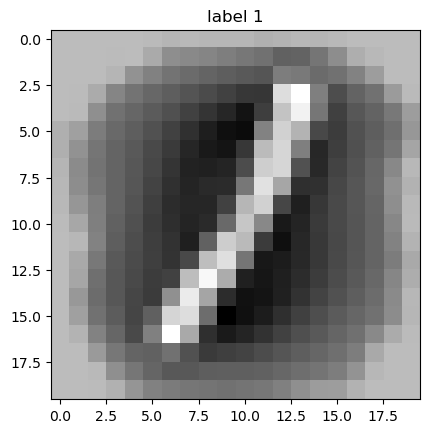

In [284]:
# tester une image
c= 3
y_pred[c]
a = Xtt[c,:].reshape((20, 20))
a=np.transpose(a)
plt.title('label '+ str(Ytt[c]))
plt.imshow(a,cmap='gray')

# les métriques de sklearn

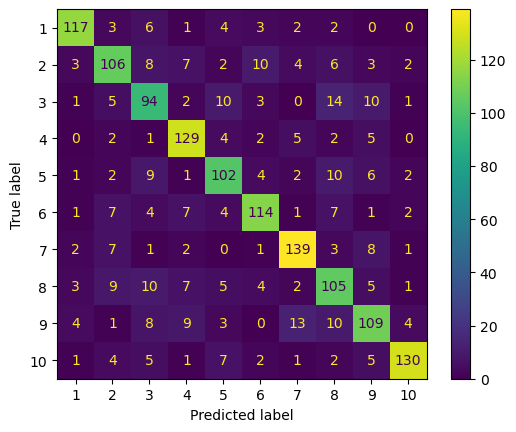

In [384]:
cm=confusion_matrix(Ytt,y_pred,labels=model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot()
plt.show()

In [387]:
print(classification_report(Ytt,y_pred))

              precision    recall  f1-score   support

           1       0.88      0.85      0.86       138
           2       0.73      0.70      0.71       151
           3       0.64      0.67      0.66       140
           4       0.78      0.86      0.82       150
           5       0.72      0.73      0.73       139
           6       0.80      0.77      0.78       148
           7       0.82      0.85      0.83       164
           8       0.65      0.70      0.67       151
           9       0.72      0.68      0.70       161
          10       0.91      0.82      0.86       158

    accuracy                           0.76      1500
   macro avg       0.76      0.76      0.76      1500
weighted avg       0.77      0.76      0.76      1500



In [385]:
print(f"Precision: {precision_score(Ytt, y_pred, average='macro')}")
print(f"Rappel:{recall_score(Ytt, y_pred, average='macro')}")

Precision: 0.7648133040468691
Rappel:0.7628053290949846


Courbe ROC avec sklearn


C:\Users\Lenovo\anaconda3\envs\my-env\lib\site-packages\sklearn\metrics\_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


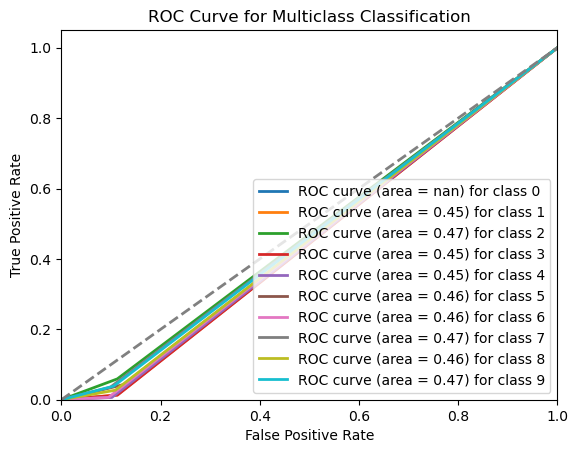

In [299]:
print("Courbe ROC avec sklearn")
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr = dict()
tpr = dict()
roc_auc = dict()
y_pred=model.predict_proba(Xtt)
for i in range(len(set(Ytt))):
    fpr[i], tpr[i], _ = roc_curve(Ytt,[y_pred[j][i] for j in range(len(y_pred))], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
lw = 2
for i in range(len(set(Ytt))):
    plt.plot(fpr[i], tpr[i], lw=lw, label='ROC curve (area = %0.2f) for class %d' % (roc_auc[i], i))
plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()


# les métriques implementées pour voir le résultat

In [388]:
M=confusionMatrix(Ytt,y_pred)
M

array([[117.,   3.,   6.,   1.,   4.,   3.,   2.,   2.,   0.,   0.],
       [  3., 106.,   8.,   7.,   2.,  10.,   4.,   6.,   3.,   2.],
       [  1.,   5.,  94.,   2.,  10.,   3.,   0.,  14.,  10.,   1.],
       [  0.,   2.,   1., 129.,   4.,   2.,   5.,   2.,   5.,   0.],
       [  1.,   2.,   9.,   1., 102.,   4.,   2.,  10.,   6.,   2.],
       [  1.,   7.,   4.,   7.,   4., 114.,   1.,   7.,   1.,   2.],
       [  2.,   7.,   1.,   2.,   0.,   1., 139.,   3.,   8.,   1.],
       [  3.,   9.,  10.,   7.,   5.,   4.,   2., 105.,   5.,   1.],
       [  4.,   1.,   8.,   9.,   3.,   0.,  13.,  10., 109.,   4.],
       [  1.,   4.,   5.,   1.,   7.,   2.,   1.,   2.,   5., 130.]])

In [402]:
print('Rappel:'+str(Rappel(M)))
print('precision :' +str(precision(M)))
print(f"Accuracy: {accuracy(M)}")
print('Specificity:'+str(specificity (M)))
print('Taux de FP:'+str(FPR(M)))

Rappel:0.7633333333333333
precision :0.7633333333333333
Accuracy: 0.5266666666666666
Specificity:-inf
Taux de FP:inf


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1928\4024345619.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  return (TN(M)/(FP(M)+TN(M)))
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1928\2444885879.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  return (FP(M) / (FP(M) + TN(M)))


# Méthode 3: RN 
Réseaux de neurones Perceptron

In [505]:
model = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(25),max_iter=100000)
Xt, Xtt, Yt, Ytt = train_test_split(X, Y, random_state=0, test_size=0.7)
model.fit(Xt, Yt)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=25, max_iter=100000, solver='sgd')

In [316]:
# Choisir un image de test 
c=0

In [317]:
model.predict([Xtt[c,:]])

array([5])

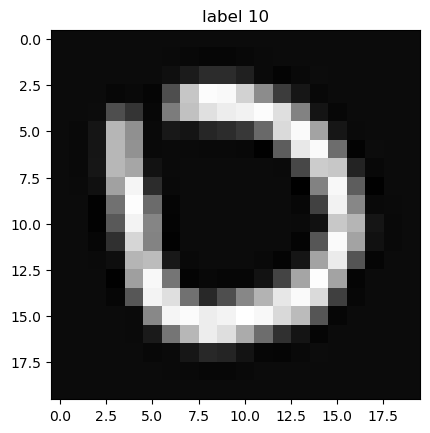

In [318]:
a = Xtt[c,:].reshape((20, 20))
a=np.transpose(a)
plt.title('label '+ str(Ytt[c]))
plt.imshow(a,cmap='gray')

In [506]:
y_pred=model.predict(Xtt)

# les métriques de sklearn

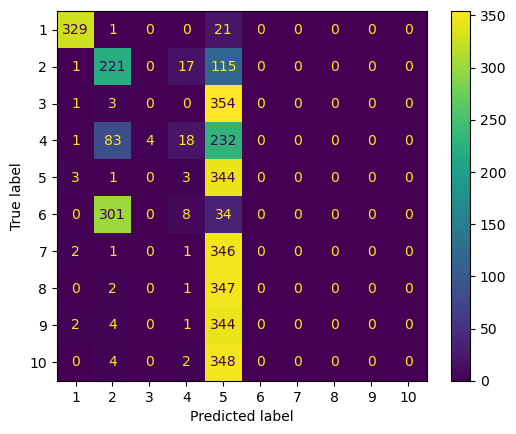

In [322]:
cm=confusion_matrix(Ytt,y_pred,labels=model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot()
plt.show()

In [508]:
from sklearn.metrics import classification_report
print(classification_report(Ytt,y_pred))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       351
           2       0.35      0.03      0.05       354
           3       0.00      0.00      0.00       358
           4       0.11      0.99      0.20       338
           5       0.00      0.00      0.00       351
           6       0.00      0.00      0.00       343
           7       1.00      0.01      0.02       350
           8       0.00      0.00      0.00       350
           9       0.00      0.00      0.00       351
          10       0.86      0.95      0.90       354

    accuracy                           0.19      3500
   macro avg       0.23      0.20      0.12      3500
weighted avg       0.23      0.19      0.12      3500



C:\Users\Lenovo\anaconda3\envs\my-env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\envs\my-env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lenovo\anaconda3\envs\my-env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [323]:
print(f"Precision: {precision_score(Ytt, y_pred, average='macro')}")
print(f"Rappel:{recall_score(Ytt, y_pred, average='macro')}")

Precision: 0.181775085164503
Rappel:0.2594927140559474


C:\Users\Lenovo\anaconda3\envs\my-env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [324]:
# pour ROC, il faudra les probabilités:
y_proba=model.predict_proba(Xtt)

Courbe ROC avec sklearn


C:\Users\Lenovo\anaconda3\envs\my-env\lib\site-packages\sklearn\metrics\_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


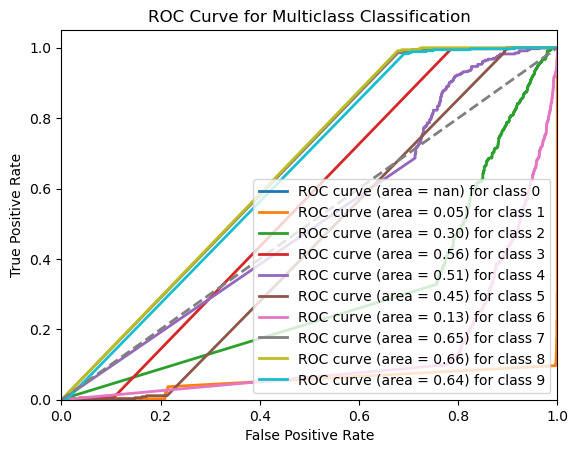

In [325]:
print("Courbe ROC avec sklearn")
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(set(Ytt))):
    fpr[i], tpr[i], _ = roc_curve(Ytt,[y_proba[j][i] for j in range(len(y_proba))], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
lw = 2
for i in range(len(set(Ytt))):
    plt.plot(fpr[i], tpr[i], lw=lw, label='ROC curve (area = %0.2f) for class %d' % (roc_auc[i], i))
plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()


# les métriques implementées pour voir le résultat

In [510]:
M=confusionMatrix(Ytt,y_pred)
M

array([[  0.,   0.,   0., 351.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   9.,   0., 319.,   0.,   0.,   0.,   0.,   0.,  26.],
       [  0.,   2.,   0., 352.,   0.,   0.,   0.,   0.,   0.,   4.],
       [  0.,   2.,   0., 335.,   0.,   0.,   0.,   0.,   0.,   1.],
       [  0.,   2.,   0., 345.,   0.,   0.,   0.,   0.,   0.,   4.],
       [  0.,   2.,   0., 334.,   0.,   0.,   0.,   0.,   0.,   7.],
       [  0.,   2.,   0., 339.,   0.,   0.,   3.,   0.,   0.,   6.],
       [  0.,   3.,   0., 346.,   0.,   0.,   0.,   0.,   0.,   1.],
       [  0.,   2.,   0., 345.,   0.,   0.,   0.,   0.,   0.,   4.],
       [  0.,   2.,   0.,  17.,   0.,   0.,   0.,   0.,   0., 335.]])

In [511]:
print('Rappel:'+str(Rappel(M)))
print('precision :' +str(precision(M)))
print(f"Accuracy: {accuracy(M)}")
print('Specificity:'+str(specificity (M)))
print('Taux de FP:'+str(FPR(M)))

Rappel:0.19485714285714287
precision :0.19485714285714287
Accuracy: -0.6102857142857143
Specificity:-inf
Taux de FP:inf


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1928\4024345619.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  return (TN(M)/(FP(M)+TN(M)))
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1928\2444885879.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  return (FP(M) / (FP(M) + TN(M)))


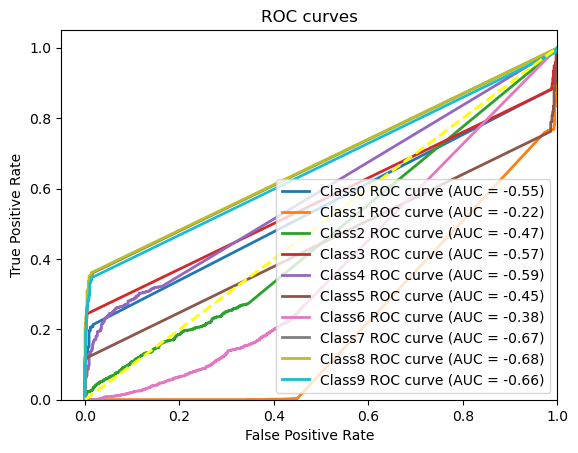

In [509]:
_,_,_,fprs1,tprs1,rocs1 =roc_class(Ytt,y_proba)
roc_figure(fprs1,tprs1,rocs1) 

# Méthode 4: RNC
Réseaux de Neurones Convolutifs

In [512]:
# reshape dataset to have a single channel
Xt, Xtt, Yt, Ytt = train_test_split(X, Y, random_state=0, test_size=0.7)

Xt_rnc = Xt.reshape((Xt.shape[0], 20, 20, 1))
Xtt_rnc = Xtt.reshape((Xtt.shape[0], 20, 20, 1))

In [513]:
# Recoder le valeurs
Yt_rnc = to_categorical(Yt)
Ytt_rnc = to_categorical(Ytt)

Xt_rncN = Xt_rnc.astype('float32')
Xtt_rncN = Xtt_rnc.astype('float32')

# normaliser
Xt_rncN = Xt_rncN / 255.0
Xtt_rncN = Xtt_rncN / 255.0

# definir le modèle RNC
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(20, 20, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(11, activation='softmax'))
# compiler le modèle
opt = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# evaluaer le modèle
Ytt_rnc.shape, Xtt_rncN.shape
_, acc = model.evaluate(Xtt_rncN, Ytt_rnc, verbose=0)

In [514]:
y_pred=model.predict(Xtt_rncN)

110/110 [==============================] - 1s 4ms/step


In [515]:
y_pred

array([[0.10863546, 0.02365967, 0.03218217, ..., 0.05471681, 0.21492082,
        0.07666679],
       [0.16855487, 0.04930812, 0.1433813 , ..., 0.09252261, 0.05664085,
        0.05724026],
       [0.16403833, 0.05181523, 0.12604208, ..., 0.10304384, 0.12067904,
        0.06336168],
       ...,
       [0.09403788, 0.07684751, 0.08161637, ..., 0.08518098, 0.08603854,
        0.0697882 ],
       [0.13011533, 0.04660143, 0.08134388, ..., 0.06779572, 0.09384425,
        0.08790886],
       [0.10332996, 0.05413371, 0.07649697, ..., 0.1474875 , 0.0897579 ,
        0.05169304]], dtype=float32)

# les métriques implementées pour voir le résultat

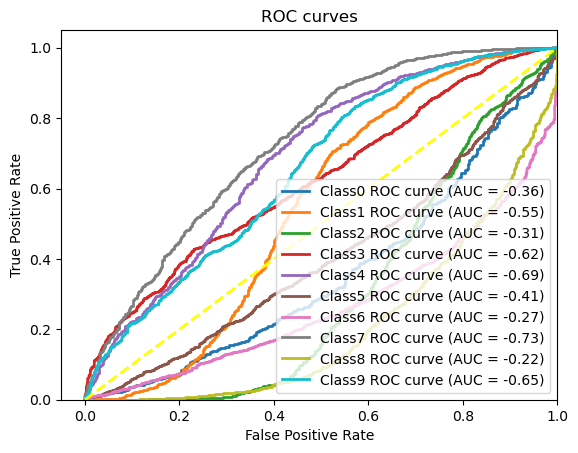

In [516]:
_,_,_,fprs1,tprs1,rocs1 =roc_class(Ytt,y_pred)
roc_figure(fprs1,tprs1,rocs1) 

In [286]:
print('Rappel:'+str(Rappel(M)))
print('precision :' +str(precision(M)))
print('Specificity:'+str(specificity (M)))
print('Taux de FP:'+str(FPR(M)))

Rappel:0.7633333333333333
precision :0.7633333333333333
Specificity:-inf
Taux de FP:inf


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1928\4024345619.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  return (TN(M)/(FP(M)+TN(M)))
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1928\2444885879.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  return (FP(M) / (FP(M) + TN(M)))


# Consignes

Le travail est à remettre par groupe de 4 au maximum [1..4].

Le délai est le mardi 14 Mars 2023 à 22h

La partie RNC peut être laissée pour le prochain TP

In [ ]:
# bonne chance   TP propose par Dr I.Setitra